# Peak Analysis
##### David M. Freestone & Fuat Balci
March 14, 2016

# 1.0 Introduction

This jupyter notebook shows how to analyze the data collected using the Psychopy Peak experiment accompanying xxx (the chapter).

First, we need to tell Python what packages and functions we'll use in this analysis script. They come in the form of import statements

In [1]:
from glob import glob     # for finding data files
from os.path import join  # for dealing with path names easily

from pandas import read_csv, concat, isnull     # reading in the data
from scipy.stats import invgauss, expon # useful distributions
from scipy.optimize import minimize     # gradient descent fitting
from numpy import (log, sqrt, hstack, histogram, # some math functions
                   argmax, zeros, zeros_like, unravel_index)     
from numba import jit # for JIT compilation

from matplotlib.pyplot import subplots, style  # for plotting
style.use("fivethirtyeight")                   # set figure style

# Import entire packages, so we can explore later.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Needed so plots show up in the jupyter notebook
%matplotlib inline

# Matplotlib spits out an annoying FutureWarning that we don't care about.
# Suppress it
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

Next we define the data directory, find all the ".csv" files in the directory, and load them all into a pandas DataFrame

In [2]:
data_directory = "data"
data_files = glob(join(data_directory, "*.csv"))
data = concat([read_csv(f) for f in data_files])

There are a lot of columns in this dataset that we'll probably never use (i.e., frameRate). It makes looking at the data easier if we remove them.

We'll also remove any event that isn't a response (like the introduction and break screens).

In [3]:
columns = ["participant", "session", "date", "time", 
           "trial_number", "response_time", 
           "score", "total_score", "reward", "cost", 
           "is_fi_trial", "is_pi_trial"]
response_idx = data.trial_number > 0
data = data.ix[response_idx, columns]

# Convert is_fi_trial to readable text
data["trial_type"] = data.is_fi_trial.map({0:"Peak", 1:"FI"})

### 2.0 Summary measures

#### 2.1 Summary statistics

In [5]:
group = ["participant", "session", "trial_type"]
data.groupby(group).response_time.agg(["mean", "std", "sem"])

mean       std       sem
participant session trial_type                              
DMF         1       FI          2.219281  1.060191  0.089924
                    Peak        3.422731  1.965924  0.267528
            2       FI          2.260153  0.996422  0.082464
                    Peak        4.246294  1.363262  0.116899
FB          1       FI          2.432896  2.902310  0.229448
                    Peak        3.863712  1.434221  0.170211
            2       FI          2.206911  1.161174  0.097444
                    Peak        4.380881  1.674037  0.141482

In [6]:
data.groupby(group).response_time.describe()

participant  session  trial_type       
DMF          1        FI          count    139.000000
                                  mean       2.219281
                                  std        1.060191
                                  min        0.000236
                                  25%        1.863929
                                  50%        2.479931
                                  75%        2.940016
                                  max        4.634060
                      Peak        count     54.000000
                                  mean       3.422731
                                  std        1.965924
                                  min        0.000268
                                  25%        2.343368
                                  50%        3.069971
                                  75%        4.405179
                                  max        8.298520
             2        FI          count    146.000000
                                  mean    

#### 2.2 Raster plots

A raster plot is a scatter plot that gives conveys the time in every trial in which a response occurs. Its a convenient way to visualize both the response time and response rate.

We'll plot the raster plot ignoring session boundaries. That is, we'll redefine trial_number to be the cumulative trial number across all sessions for a given trial type (i.e., separating Fixed Interval and Peak Interval trials).

In [7]:
def cumulative_trial(x):
    """Return the cumulative trial numbers ignoring session boundaries"""
    x = hstack((0, x))
    return (x[:-1] != x[1:]).cumsum()

# Now apply the function on the trial_number column (transform), 
#   grouping by participant and trial type
group = ["participant", "trial_type"]
data["cumulative_trial"] = data.groupby(group).trial_number.transform(cumulative_trial)

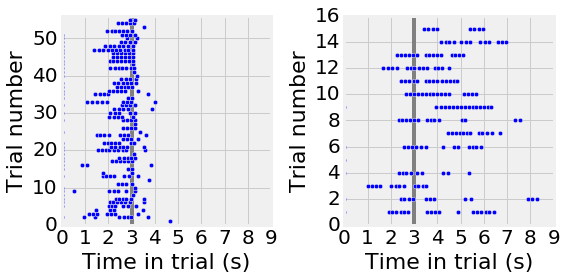

In [9]:
def plot_raster(ax, x, y):
    """Plot the raster plot"""
    ax.vlines(3, 0, 1+y.max(), color="gray", zorder=1)
    ax.scatter(x, y, s=20)
    ax.set_xlim((0, 9))
    ax.set_ylim((0, 1+y.max()))
    ax.set_ylabel("Trial number", fontsize=22)
    ax.set_xlabel("Time in trial (s)", fontsize=22)
    ax.tick_params(labelsize=20)
    return None


# Plot the raster for DMF with FI and Peak side-by-side.
p_idx = data.participant == "DMF"
fi_idx = data.trial_type == "FI"

fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
plot_raster(ax[0], 
            data.ix[p_idx & fi_idx, "response_time"],
            data.ix[p_idx & fi_idx, "cumulative_trial"])
plot_raster(ax[1], 
            data.ix[p_idx & ~fi_idx, "response_time"],
            data.ix[p_idx & ~fi_idx, "cumulative_trial"])
fig.tight_layout()

#### 2.3 Response gradient

A response gradient is a scaled histogram so that the units are responses per minute.

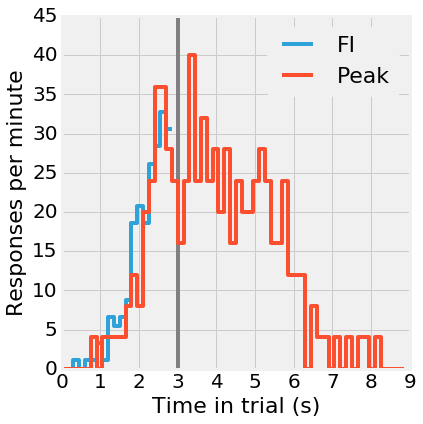

In [13]:
def response_gradient(df, binsize, end_time):
    """Return the histogram scaled to responses per minute"""
    nbins = int(end_time / binsize)
    
    times = df.response_time
    ntrials = df.cumulative_trial.max()
    weights = (60/ntrials) + zeros_like(times)
    
    count, bins = histogram(times, bins=nbins, range=(0, end_time), weights=weights)
    bins = bins[:-1]
    return count, bins

def plot_response_gradient(ax, df, binsize, end_time, label=None):
    """Plot the response gradient"""
    count, bins = response_gradient(df, binsize, end_time)
    ax.step(bins, count, label=label)
    ax.vlines(3, 0, ax.get_ylim()[1], color="gray", zorder=1)
    ax.set_xlim((0, end_time))
    ax.set_ylim(bottom=0)
    ax.tick_params(labelsize=20)
    ax.set_xlabel("Time in trial (s)", fontsize=22)
    ax.set_ylabel("Responses per minute", fontsize=22)
    
    
# Plot the DMF data as responses per minute
fig, ax = plt.subplots(figsize=(6,6))
plot_response_gradient(ax, data[p_idx & fi_idx], 0.15, 3, label="FI")
plot_response_gradient(ax, data[p_idx & ~fi_idx], 0.15, 9, label="Peak")
ax.legend(fontsize=22)
fig.tight_layout()

### 2.4 Statistics of the Peak curve

In the chapter, we discuss several ways of obtaining statistics from the peak gradient. The first is nonparametric (i.e., without assuming a distribution form), and the second is parametric. The parametric approach is often a little more challenging to implement, but it can be prefered because it jointly estimates all the statistics at once. In addition, it does not require any further processing of the data (e.g., smoothing).

For the peak data, we want to obtain the peak time, spread, and amplitude. The first two come from the parameters of an appropriate distribution (say, normal), and the amplitude comes from scaling that distribution).

When the data is normally distributed, the best fitting normal distribution has as its parameters the mean and standard deviation of the response times themselves. Note this is only true in Peak data, not in FI data, because FI data is not normally distributed. For FI data, or data that is not normally distributed, the appropriate distribution should be fit to the data (see the DRL_Analysis.ipynb file for an example).

In [94]:
pi_trials = data[data.trial_type == "Peak"]

peak_statistics = pi_trials.groupby(["participant"]).response_time.agg(["mean", "std"])
peak_statistics["CoV"] = peak_statistics["std"] / peak_statistics["mean"]

peak_statistics

,mean,std,CoV
participant,,,
DMF,4.012229,1.596870,0.398001
FB,4.206857,1.612633,0.383334


The peak amplitude is the response rate at the peak. This of course depends on the bin size used to construct the response rate gradient because the response rate at the exact peak time is arbitrarily small. 

In [104]:
def peak_amplitude(df, binsize):
    """Return the peak amplitude assuming a normal distribution"""
    t = df.response_time
    n = df.cumulative_trial.max()
    
    μ = t.mean()
    μ_lowerbin = μ-binsize/2
    μ_upperbin = μ+binsize/2
    count = ((μ_lowerbin <= t) & (t < μ_upperbin)).sum()
    return 60 * (count/n)

peak_statistics["amplitude"] = pi_trials.groupby("participant").apply(peak_amplitude, 0.15)

peak_statistics

,mean,std,CoV,amplitude
participant,,,,
DMF,4.012229,1.596870,0.398001,28.000000
FB,4.206857,1.612633,0.383334,43.333333


### 3.0 Finding the start and stop times

The most common way to find the start and stop times is to use the Church, Meck, & Gibbon (CMG; 1994) change-point algorithm. For start times, it is formally equivalent to Gallistel, Fiarhurst, & Balsam (2004), and both are special cases of the OLS-CUSUM method in econometrics (Ploberger & Kramer, 1992).

Intuitively, the CMG algorithm finds the point at which the response rate before and after the transition point together maximally deviate from the average response rate (see xx figure x). 

The start and stop times are the times $t_1$ and $t_2$ that maximize the equation

$$t_1(r-r_1) + t_2(r_2-r) + t_3(r-r_3)$$

where $t_1$ and $t_2$ are times in the trial, and $r_1$, $r_2$, $r_3$ are the response rates in the first, second, and third segments (low-high-low states), and $r$ is the overall response rate. For FI trials, where there is no meaningful stop time, the equation reduces to

$$t_1(r-r_1) + t_2(r_2-r)$$

Since we often compute the transition point over hundreds or thousands of trials or more, we'll use Just In Time (JIT) compilation to speed up the code

In [14]:
@jit(nopython=True)
def start_time(times, end_time):
    """Return the start time on a trial using CMG 1994"""
    n, t = times.size, end_time
    r = n / t
    CMG = zeros(n)
    for i in range(n):
        t1, t2 = times[i], t - times[i]
        n1, n2 = 1+i, 1+(n-i)  # add one bc python is 0-based indexing

        r1 = n1 / t1
        r2 = n2 / t2
        
        CMG[i] = t1*(r-r1) + t2*(r2-r)
    return times[argmax(CMG)]
 
def gstart_time(t):
    """Wrapper for start_time
        Because we used JIT compilation on the above functions
        to compile them down to machine code (to speed things up),
        we can't pass in DataFrame or Series objects. 
        Here's a simple wrapper that converts the Series to an
        array that can be safely passed to our JITed function.
    """
    end_time = 3
    return start_time(t.as_matrix(), end_time)

### 3.1 Finding the start times on FI trials

In [15]:
fi_trials = data[data.trial_type == "FI"]

This analysis works on each individual trial for each participant and session, so we need to group by these variables. But since we already got the cumulative trial (ignoring session), we can just group by participant and cumulative trial.

In [24]:
# Wrap in () so we can split lines at its readable joints
starts = (data.groupby(["participant", "cumulative_trial"])
              .response_time
              .agg(gstart_time)
          )

# convert from pandas Series to DataFrame, and rename the result
starts = pd.DataFrame(starts).reset_index()
starts = starts.rename(columns={"response_time": "start_time"})

Get the mean start time over our subjects for each trial

In [40]:
mean_starttime = starts.groupby("cumulative_trial").agg(["mean", "sem"])
mean_starttime = mean_starttime.reset_index()

Now plot, with errorbars.

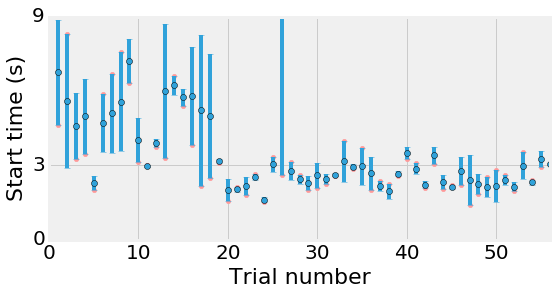

In [55]:
dmf_idx = starts.participant == "DMF"

x = starts.ix[dmf_idx, "cumulative_trial"]
y = starts.ix[dmf_idx, "start_time"]

fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(mean_starttime["cumulative_trial"],
             mean_starttime.start_time["mean"],
             mean_starttime.start_time["sem"],
             linestyle="", fmt="o")
ax.scatter(x, y, color="#ff9999")

ax.set_xlim((0, 1+x.max()))
ax.set_ylim((0, 9))
ax.set_xlabel("Trial number", fontsize=22)
ax.set_ylabel("Start time (s)", fontsize=22)
ax.tick_params(labelsize=20)
ax.set_yticks([0, 3, 9]);

### 3.2 Finding the start and stop times on Peak trials

As we note in the chapter, human data is often much easier to analyze at the single trial level because the first response is often a good estimate of the start time and the last response is often a good estimate of the stop time.

If this isn't true in your data, it is relatively straightforward to extend the CMG algorithm written above to the start-stop times. We use the first and last response here to allow us to show both approaches.

In [111]:
def start_stop_time(t):
    """Return the start and stop time
        assuming the start is the first response
        and the stop is the last response
    """
    return t.iloc[0], t.iloc[-1]

In [124]:
pi_trials = data[data.trial_type == "Peak"]

# In python, its easy to chain commands together in a human readable way.
starts_stops = (pi_trials.groupby(["participant", "cumulative_trial"])
                         .response_time           # operate on the response_time column
                         .apply(start_stop_time)  # apply the function
                         .apply(pd.Series)        # convert output to separate columns
                         .reset_index()           # turn indices into columns
                         .rename(columns={0:"start_time", 1:"stop_time"})      # give the output useful names
                )

mean_start_stops = starts_stops.groupby("cumulative_trial").agg(["mean", "sem"])
mean_start_stops = mean_start_stops.reset_index()

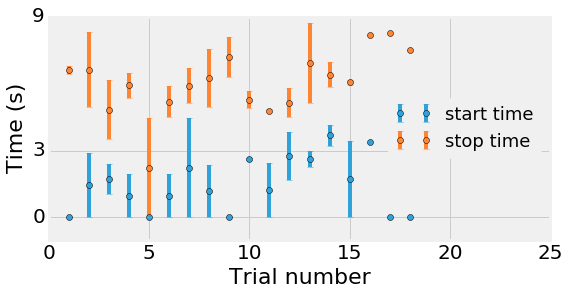

In [140]:
# This code is mostly copy/paste from above. 
# For generality, this could go into a separate function
fig, ax = plt.subplots(figsize=(8,4))
ax.errorbar(mean_start_stops["cumulative_trial"],
             mean_start_stops.start_time["mean"],
             mean_start_stops.start_time["sem"],
             linestyle="", fmt="o",
             label="start time")
ax.errorbar(mean_start_stops["cumulative_trial"],
             mean_start_stops.stop_time["mean"],
             mean_start_stops.stop_time["sem"],
             linestyle="", fmt="o", color="#ff8533",
             label="stop time")

ax.set_xlim((0, 25))
ax.set_ylim((-1, 9))
ax.set_xlabel("Trial number", fontsize=22)
ax.set_ylabel("Time (s)", fontsize=22)
ax.tick_params(labelsize=20)
ax.set_yticks([0, 3, 9]);
ax.legend(loc="center right", fontsize=18)

### 3.3 Single trial peak and spread

The spread is the temporal distance between the start and stop times ($stop - start$). The peak is often defined as the midpoint between the two

In [146]:
starts_stops["spread"] = starts_stops["stop_time"] - starts_stops["start_time"]
starts_stops["peak"] = (starts_stops["stop_time"] + starts_stops["start_time"]) / 2

In [148]:
starts_stops.groupby("participant").agg(["mean", "sem"])

cumulative_trial           start_time           stop_time  \
                        mean       sem       mean       sem      mean   
participant                                                             
DMF                      8.0  1.154701   1.631637  0.417475  5.536975   
FB                       9.5  1.258306   1.397569  0.354272  6.195696   

                         spread                peak            
                  sem      mean       sem      mean       sem  
participant                                                    
DMF          0.503303  3.905339  0.567949  3.584306  0.364909  
FB           0.335914  4.798127  0.477039  3.796632  0.249563